# RAG Powered Tool Calling

In [9]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv

load_dotenv()

True

### Function to Retrieve a bible text from api and combine it as one text chunk

In [10]:
import requests
import re

## get bible passage from https://bible-api and return a string version of the bible

def bible_text(passage: str) -> str:
    """
    Fetches a Bible passage from Bible-API and returns it in a formatted string:
    Example: "Luke 15:1-2 1. Text 2. Text"
    """
    url = f"https://bible-api.com/{passage.replace(' ', '%20')}?translation=kjv"
    response = requests.get(url)
    
    if response.status_code != 200:
        return f"Error fetching passage: {response.status_code}"

    data = response.json()
    reference = data.get("reference", "")
    verses = data.get("verses", [])
    
    merged_verses = " ".join(
        [f'{v["verse"]}. {v["text"].strip()}' for v in verses]
    )
    final_text = f"{reference} {merged_verses}"
    cleaned_text =re.sub(r'\s+', ' ', final_text).strip()

    return cleaned_text



### Retrieve the text using the bible_text function and store it as a list of Documents

In [11]:
docs =[
Document(page_content=bible_text("Luke 15"), metadata={"source":"Luke 15"}),
Document(page_content=bible_text("Psalm 1"), metadata={"source":"Psalm 1"}),
Document(page_content=bible_text("Psalm 124"), metadata={"source":"Psalm 124"}),
Document(page_content=bible_text("Psalm 2"), metadata={"source":"Psalm 2"}),

] 


### Create Embedding (OpenAIEmbeddings), chroma db (Chroma.from_documents) and retriever (db.as_retriever)

In [12]:
embedding_function = OpenAIEmbeddings()
db = Chroma.from_documents(docs, embedding_function)
retriever =db.as_retriever(search_type="mmr", search_kwargs={"k":3})

### NEW implementation - Tools Declaration there

In [13]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to bible history, stories, parables and everything about bible"

)

@tool
def off_topic():
    """ catch all topic not related to bible or christianity"""
    return "Forbidden - do no respond to the user"


tools = [retriever_tool,off_topic]

 

### Instantiate AgentState as Typedict 

In [15]:
from typing import Sequence, Annotated, Literal, TypedDict 
from langgraph.graph import StateGraph, END, add_messages
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]
    

### add node

In [17]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START

def agent(state:AgentState):
    messages = state["messages"]
    model = ChatOpenAI()
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages":[response]}

def should_continue(state:AgentState)->Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

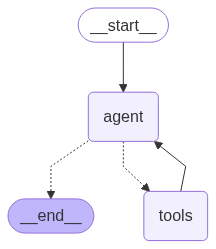

In [20]:
from langgraph.graph import END,START, StateGraph
from langgraph.prebuilt import ToolNode

workflow = StateGraph(AgentState)
workflow.add_node("agent", agent)

tool_node = ToolNode(tools)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue
)
workflow.add_edge("tools","agent")

graph = workflow.compile()
graph

### Execute a question

In [22]:
result = graph.invoke(
    input = {
        "messages":[HumanMessage(content="Why do you think killing the fatted calf made the brother angry")]
    }
)
print("==========ANSWER===============\n")
print(result["messages"][-1].content)

==========ANSWER===============

The story of the killing of the fatted calf and the anger of the brother is found in the Bible in the book of Luke, chapter 15. The parable is about a father who welcomes back his younger son who had strayed and returned home. The father celebrates his return by ordering the killing of the fatted calf and holding a feast.

The elder son, who had remained faithful and obedient to his father, becomes angry when he learns about the celebration for his younger brother. He feels neglected and unappreciated despite his years of service. The killing of the fatted calf for his brother, who had squandered his share of the inheritance, causes resentment and jealousy in the elder son.

This parable illustrates themes of forgiveness, redemption, and the challenge of accepting grace and mercy. The anger of the elder son highlights the struggle of human nature to overcome feelings of entitlement, pride, and comparison with others.


In [23]:
result = graph.invoke(
    input = {
        "messages":[HumanMessage(content="how good is Panasonic GH7 camera")]
    }
)
print("==========ANSWER===============\n")
print(result["messages"][-1].content)

==========ANSWER===============

I couldn't find a specific review for the Panasonic GH7 camera. However, I retrieved some passages from the Bible. Would you like me to search for more information or do you have any other questions?
